# Elements of Data Science: A First Course 

# COMS W4995 008 2017 3


## Week 8: Project Reporting and Application: Time Series

In [1]:
import pandas as pd
import numpy as np

# To suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

np.random.seed(123)

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.plotly as py
from plotly import tools as plotly_tools
import cufflinks as cf

import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

sns.set_style('whitegrid')

## Reading: 

- (Timeseries Review: PDSW CH3 pp 188-208)
- Dimensionality Reduction: PDSW CH5 In Depth: Principal Component Analysis
- Image Recognition: PDSW CH5 Application: A Face Detection Pipeline

## Today

 - (From last lecture)
  - ROC and AUC
  - Regularization
  - Feature Selection


- Project Reporting
  - Tools
  - Matplotlib figure review

 - Time Series
  - resampling
  - windowing
  - shifting

## Project Reporting

### Things to include (recommended)

 - restate the problem

 - get the results upfront

 - methodology for reproducibility

 - data dictionary

## Reporting tools

### Jupyter notebook (review)
  - Markup
  - Images
  - Latex
  - Slides

 - to create slides: https://bit.ly/2T1vMgV
 - to view interactively online: https://nbviewer.jupyter.org/

Examples:  
https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks


### Interactive Graphs
  - Bokeh
  - Plotly

### Dashboards
  - Dash
  - Tableau, PowerBI

Examples:  
https://dash.plot.ly/gallery  
https://dash-dashboard-example.herokuapp.com/  
https://dash-oil-and-gas.plot.ly/

## Matplotlib review

 - figure
 - axis
 - subplots

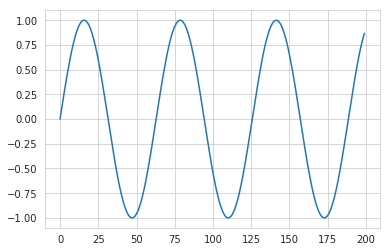

In [2]:
x = np.array(range(0,200))*.1
plt.plot(np.sin(x))

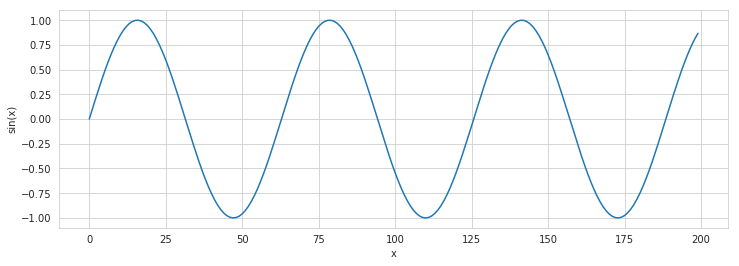

In [3]:
fig = plt.figure(figsize=(12,4))
_ = plt.plot(np.sin(x))
_ = plt.xlabel('x')
_ = plt.ylabel('sin(x)')

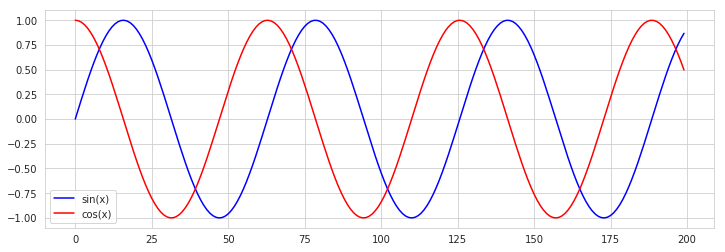

In [4]:
# plotting twice on the same axis
fig = plt.figure(figsize=(12,4));
plt.plot(np.sin(x),color='b',label='sin(x)');
plt.plot(np.cos(x),color='r',label='cos(x)');
plt.legend();

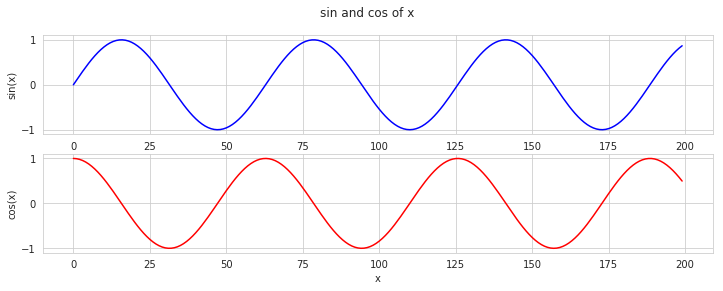

In [5]:
# plotting in subplots
fig,ax = plt.subplots(2,1,figsize=(12,4))
ax[0].plot(np.sin(x),color='b',label='sin(x)');
ax[0].set_xlabel('x');
ax[0].set_ylabel('sin(x)');
ax[1].plot(np.cos(x),color='r',label='cos(x)');
ax[1].set_xlabel('x');
ax[1].set_ylabel('cos(x)');
fig.suptitle('sin and cos of x');

In [6]:
#plotting using plotly and fig
#pyo.iplot_mpl(fig)

## TimeSeries

 - Issues
 - Datetimes in pandas 
  - Timestamp
  - Timedelta
 - Resampling
  - Downsampling
  - Upsampling
 - Windowing
 - Shifting


### Timeseries Issues

 - non-iid!

 - seasonality

### Datetimes in pandas: Timestamp

In [7]:
from datetime import datetime

In [8]:
# Year Month Day Hour Minute Second
datetime(2017, 11, 2, 19, 45, 55)

datetime.datetime(2017, 11, 2, 19, 45, 55)

In [9]:
# pandas can handle many date formats
dates = pd.to_datetime([datetime(2015, 7, 3),
                        '4th of July, 2015',
                        '2015-Jul-6',
                        '07-07-2015',
                        '20150708'])
dates

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
               '2015-07-08'],
              dtype='datetime64[ns]', freq=None)

In [10]:
# dates may not get processed on DataFrame creation
df = pd.DataFrame({'date': ['2014-07-04',
                    '2014-08-04',
                    '2015-07-04',
                    '2015-08-04'],
                   'val': [2,4,6,8]})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
date    4 non-null object
val     4 non-null int64
dtypes: int64(1), object(1)
memory usage: 144.0+ bytes


In [11]:
# can covert using pd.to_datetime()
df.date = pd.to_datetime(df.date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
date    4 non-null datetime64[ns]
val     4 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 144.0 bytes


In [12]:
# often useful to set date as index
df.set_index('date', inplace=True)
df

val
date           
2014-07-04    2
2014-08-04    4
2015-07-04    6
2015-08-04    8

In [13]:
# can then index by date
df['2014-07-04':'2015-07-04']

val
date           
2014-07-04    2
2014-08-04    4
2015-07-04    6

In [14]:
# indexing is also flexible
df['2015']

val
date           
2015-07-04    6
2015-08-04    8

### Datetimes in pandas: Timedelta

In [15]:
# Timedelta: the difference between datetimes 
df.index[1] - df.index[0]

Timedelta('31 days 00:00:00')

In [16]:
# can operate over entire sets
df.index - df.index[0]

TimedeltaIndex(['0 days', '31 days', '365 days', '396 days'], dtype='timedelta64[ns]', name='date', freq=None)

In [17]:
# works with series as well
s = pd.to_datetime(pd.Series(['2014-07-04','2014-08-04','2015-07-04','2015-08-04']))
s - s[0]

0     0 days
1    31 days
2   365 days
3   396 days
dtype: timedelta64[ns]

### Example Dataset: Twitter stock price

In [18]:
#from pandas_datareader import data
#twtr = data.DataReader('TWTR', start='2013', end='2018',
#                        data_source='yahoo')

twtr = pd.read_csv('../data/twtr_2013-2018.csv',parse_dates=['Date'])
twtr = twtr.set_index('Date')
twtr.head()

High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2013-11-07  50.090000  44.000000  45.099998  44.900002  117701600  44.900002
2013-11-08  46.939999  40.689999  45.930000  41.650002   27925300  41.650002
2013-11-11  43.000000  39.400002  40.500000  42.900002   16113900  42.900002
2013-11-12  43.779999  41.830002  43.660000  41.900002    6316700  41.900002
2013-11-13  42.869999  40.759998  41.029999  42.599998    8688300  42.599998

In [19]:
# for simplicity, just using Close
twtr = twtr.Close

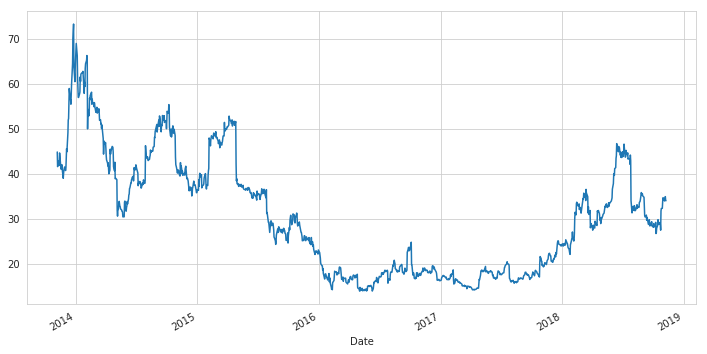

In [20]:
# simple line plot
fig = plt.figure()
twtr.plot(figsize=(12,6));

In [21]:
# creating the same plot in plotly using cufflinks
#cf.set_config_file(offline=True, world_readable=False, theme='ggplot')
#twtr.iplot()

In [22]:
# a simpler method to convert from matplotlib to plotly
#pyo.iplot_mpl(fig)

### Resampling

- **downsampling**: rougher reslution (days -> months)

- **upsampling**: finer resolution (months -> days)

In [23]:
# downsampling to business quarter using resample
# resample allows for summarization (like groupby)
twtr_BQ = twtr.resample('BQ')
twtr_BQ

DatetimeIndexResampler [freq=<BusinessQuarterEnd: startingMonth=12>, axis=0, closed=right, label=right, convention=start, base=0]

In [24]:
# note the frequency and the interval
twtr_BQ.mean().head(3)

Date
2013-12-31    49.657568
2014-03-31    56.587049
2014-06-30    37.854603
Freq: BQ-DEC, Name: Close, dtype: float64

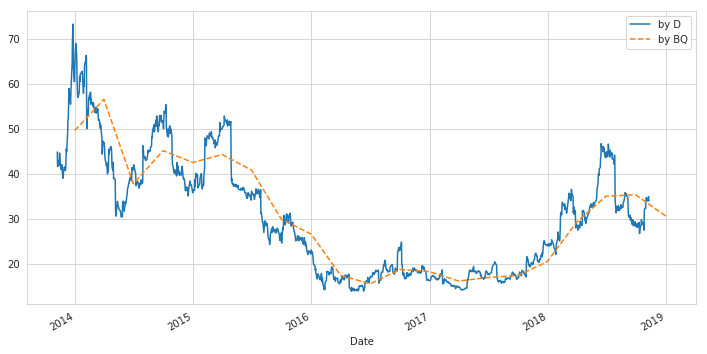

In [25]:
# plotting both
fig = plt.figure(figsize=(12,6))
_ = twtr.plot(style='-', label='by D')
_ = twtr_BQ.mean().plot(style='--', label='by BQ')
_ = plt.legend(loc='upper right');

In [26]:
# plotting using plotly
# need to deal with missing values in twtr_BQ
#tmp = pd.DataFrame({'twtr':twtr,'twtr_BQ':twtr_BQ.mean()})
#tmp.interpolate().iplot()

In [27]:
#pyo.iplot_mpl(fig)

In [28]:
# what about upsampling? 
# need asfreq to convert from ResamplerObject
twtr_H = twtr.resample('H')
twtr_H.asfreq().head(3)

Date
2013-11-07 00:00:00    44.900002
2013-11-07 01:00:00          NaN
2013-11-07 02:00:00          NaN
Freq: H, Name: Close, dtype: float64

In [29]:
twtr_H.ffill().head(3)

Date
2013-11-07 00:00:00    44.900002
2013-11-07 01:00:00    44.900002
2013-11-07 02:00:00    44.900002
Freq: H, Name: Close, dtype: float64

In [30]:
twtr.index

DatetimeIndex(['2013-11-07', '2013-11-08', '2013-11-11', '2013-11-12',
               '2013-11-13', '2013-11-14', '2013-11-15', '2013-11-18',
               '2013-11-19', '2013-11-20',
               ...
               '2018-10-29', '2018-10-30', '2018-10-31', '2018-11-01',
               '2018-11-02', '2018-11-05', '2018-11-06', '2018-11-07',
               '2018-11-08', '2018-11-09'],
              dtype='datetime64[ns]', name='Date', length=1262, freq=None)

### Windowing

In [31]:
# create a centered rolling window of one year
rolling = twtr.rolling(365, center=True)
rolling

Rolling [window=365,center=True,axis=0]

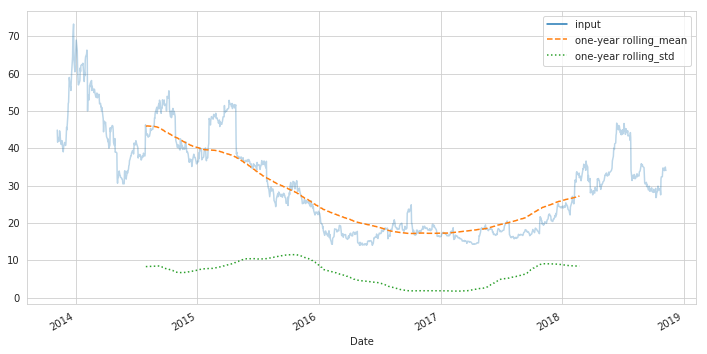

In [32]:
# plot mean and std of one year rolling window
data = pd.DataFrame({'input': twtr,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})

ax = data.plot(style=['-', '--', ':'], figsize=(12,6))
ax.lines[0].set_alpha(0.3)

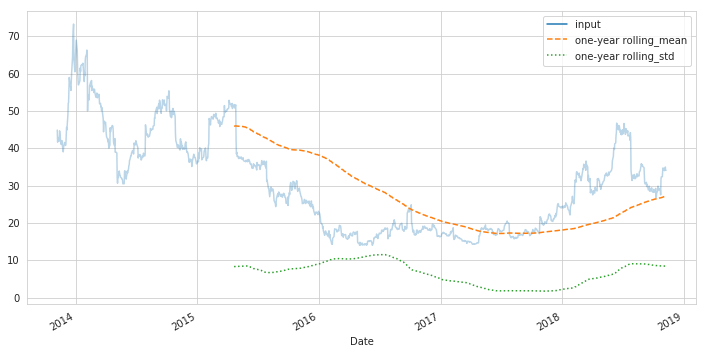

In [33]:
# create another rolling window, without centering
rolling = twtr.rolling(365, center=False)
data = pd.DataFrame({'input': twtr,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})

ax = data.plot(style=['-', '--', ':'], figsize=(12,6))
ax.lines[0].set_alpha(0.3)

### Shifting

In [34]:
# apply a frequency to the data
print('original freq: ', twtr.index.freq)
twtr.head(3)

original freq:  None


Date
2013-11-07    44.900002
2013-11-08    41.650002
2013-11-11    42.900002
Name: Close, dtype: float64

In [35]:
# setting fill for missing values
twtr_D = twtr.asfreq('D', method='ffill')

print('new freq     : ',twtr_D.index.freq)
twtr_D.head(3)

new freq     :  <Day>


Date
2013-11-07    44.900002
2013-11-08    41.650002
2013-11-09    41.650002
Freq: D, Name: Close, dtype: float64

In [36]:
# shift data 1 year (a year later)
twtr_1Y = twtr_D.tshift(-365)
twtr_1Y.head(3)

Date
2012-11-07    44.900002
2012-11-08    41.650002
2012-11-09    41.650002
Freq: D, Name: Close, dtype: float64

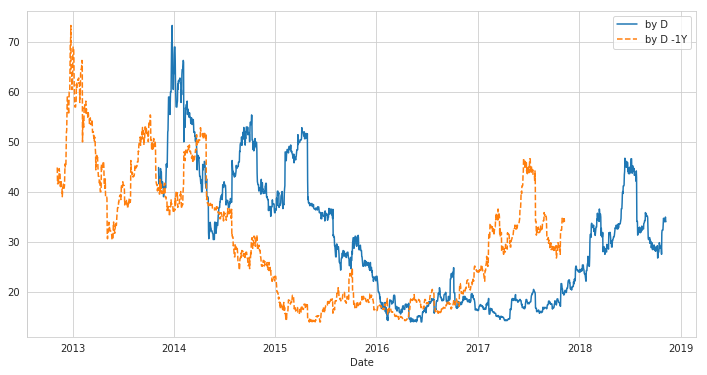

In [37]:
# plotting shifted data
fig = plt.figure(figsize=(12,6))
_ = twtr_D.plot(style='-',label='by D')
_ = twtr_1Y.plot(style='--', label='by D -1Y')
_ = plt.legend()

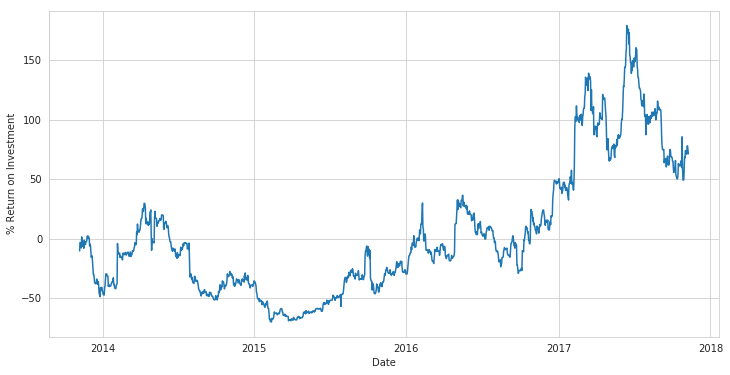

In [38]:
# calculate return on investment;
# (ending price - beginning price) / beginning price
ROI = (twtr_1Y - twtr_D) / twtr_D *100

fig = plt.figure(figsize=(12,6))
_ = ROI.plot(label='ROI')
plt.ylabel('% Return on Investment');

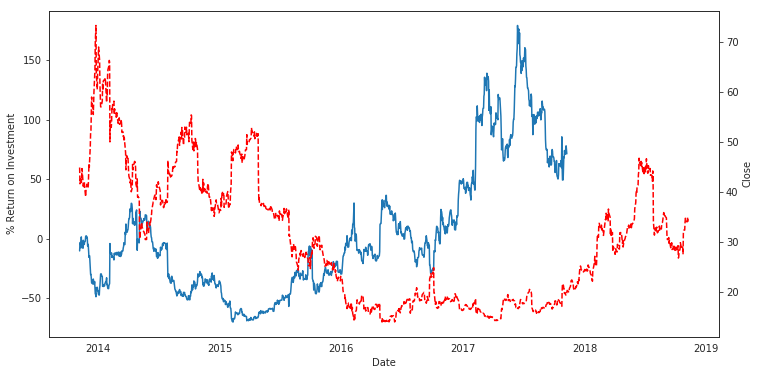

In [39]:
# plot ROI on shared axis with close

with sns.axes_style('white'):
    fig,ax1 = plt.subplots(1,1,figsize=(12,6))
    _ = ROI.plot(label='ROI',ax=ax1)
    _ = ax1.set_ylabel('% Return on Investment');
    
    ax2 = ax1.twinx()
    _ = twtr.plot(style='--',color='r',ax=ax2)
    _ = ax2.set_ylabel('Close');

## Example:

In [40]:
# Gather data of bike activity on Fremont Bridge from 2012-2017
# !curl -o ../data/FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

In [41]:
# load the data
data = pd.read_csv('../data/FremontBridge_2015-2017.csv.zip', index_col='Date', parse_dates=True)
data.head(3)

Fremont Bridge West Sidewalk  \
Date                                                
2015-01-01 00:00:00                           4.0   
2015-01-01 01:00:00                           4.0   
2015-01-01 02:00:00                           5.0   

                     Fremont Bridge East Sidewalk  
Date                                               
2015-01-01 00:00:00                           9.0  
2015-01-01 01:00:00                          23.0  
2015-01-01 02:00:00                          14.0

In [42]:
# shorten column names and create Total column
data.columns = ['West', 'East']
data['Total'] = data.eval('West + East')

In [43]:
# drop any rows with missing values
print(len(data.dropna())/ len(data))
data.dropna(inplace=True)

0.9997987117552335


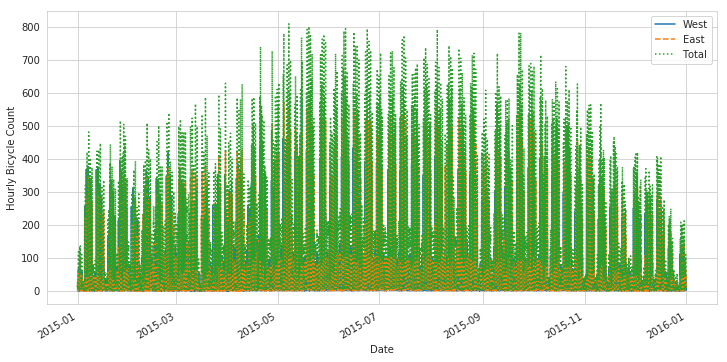

In [44]:
# plot data from 2015
data['2015'].plot(style=['-', '--', ':'],figsize=(12,6))
plt.ylabel('Hourly Bicycle Count');

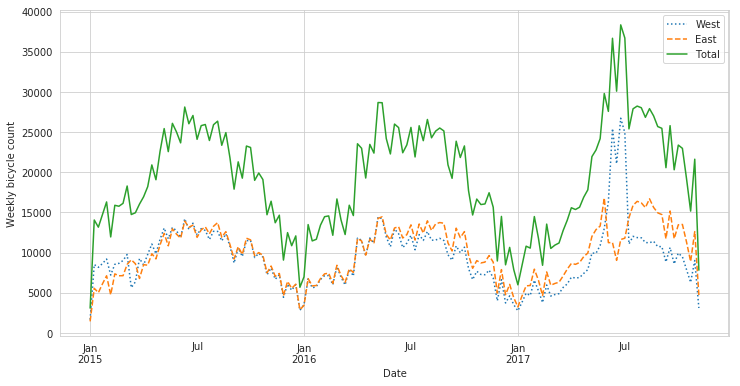

In [45]:
# downsample to weekly sum to smooth things out
weekly = data.resample('W').sum()
weekly.plot(style=[':', '--', '-'], figsize=(12,6))
plt.ylabel('Weekly bicycle count');

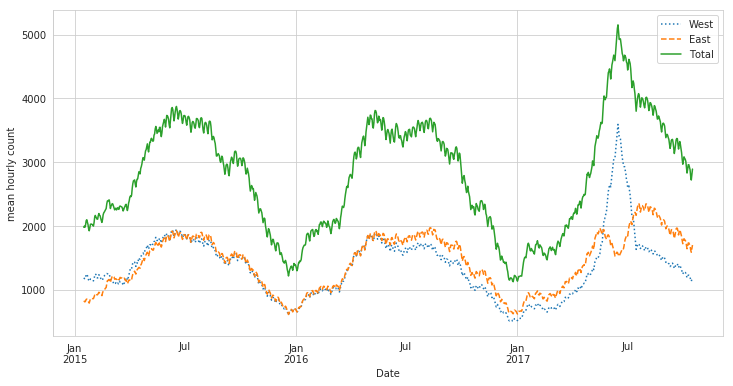

In [46]:
# resample at daily for a more granular view
# then apply a rolling window of 30 days to smooth things out
daily = data.resample('D').sum()
daily.rolling(30, center=True).mean().plot(style=[':', '--', '-'], figsize=(12,6))
plt.ylabel('mean hourly count');

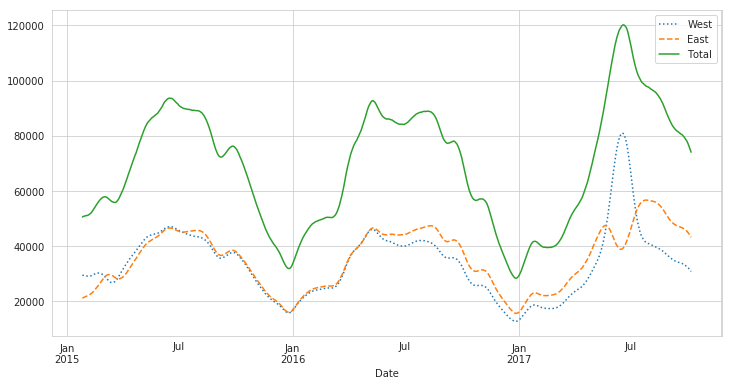

In [47]:
# a wider window using a gaussian filter smooths more while 
# accentuating daily differences
daily.rolling(50, center=True,
              win_type='gaussian').sum(std=10).plot(style=[':', '--', '-'],
                                                    figsize=(12,6));

In [48]:
# the same plot in plotly
#daily.rolling(50, center=True,
#              win_type='gaussian').sum(std=10).iplot();

In [49]:
#if we want to only look at time of day
data.index.time

array([datetime.time(0, 0), datetime.time(1, 0), datetime.time(2, 0), ...,
       datetime.time(21, 0), datetime.time(22, 0), datetime.time(23, 0)],
      dtype=object)

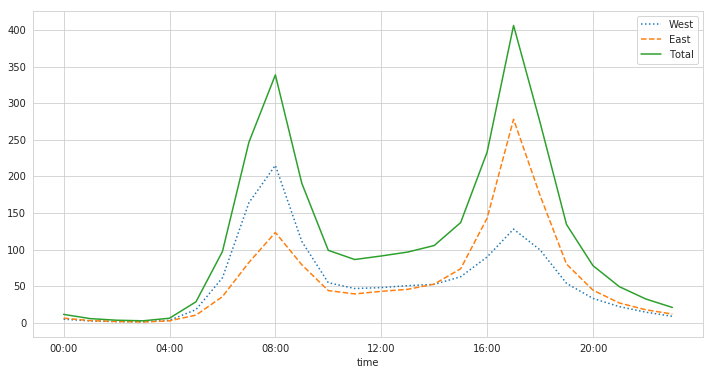

In [50]:
# get mean data by time (hourly)
by_time = data.groupby(data.index.time).mean()
# create xticks every 4 hours
hourly_ticks = 60 * 60 * 4 * np.arange(6)  # sec * min * every4hours
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-'], figsize=(12,6));

In [51]:
# can also look at average by day of week
by_weekday = data.groupby(data.index.dayofweek).mean()

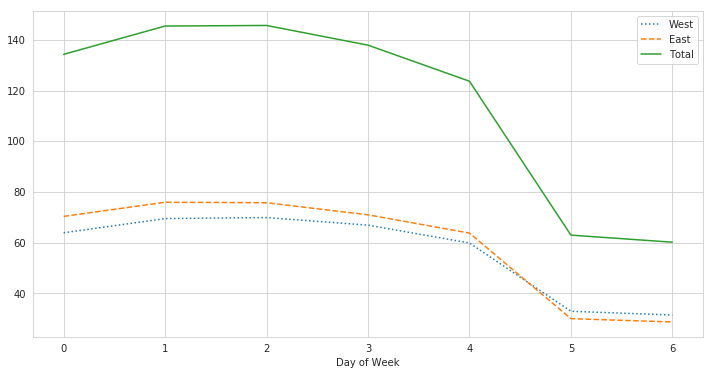

In [52]:
# BUG: can't seem to plot with renamed index
day_names = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
fig,ax = plt.subplots(1,1,figsize=(12,6))
by_weekday.plot(style=[':', '--', '-'], ax=ax);
ax.set_xlabel('Day of Week');

In [53]:
# create a weekend mask
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
# get hourly mean values split by weekday, weekend
by_time = data.groupby([weekend, data.index.time]).mean()

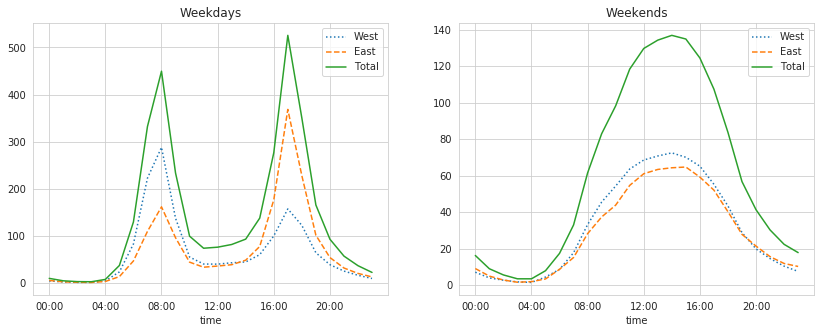

In [54]:
# plot weekday and weekend hourly summary separately
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);